#### Install necessary python packages

* `fair-esm` - protein language model package
* `plotly` - plotting

In [ ]:
!pip install fair-esm plotly

#### Import the packages


In [ ]:
from typing import List, Tuple # type hints - to indicate type of the value

import esm # protein language model
import matplotlib.pyplot as plt # plotting
import pandas as pd # tables manipulation
import plotly.express as px # plotting
import torch # neural network
from sklearn.decomposition import PCA # Principal component analysis 
import torch
import torch.nn.functional as F

### Quick intro to neural networks

Let's say we have a small dataset of how students performed on an exam, based on the amount of time they slept, studied and partied before an exam.

|           | Time sleeping | Time studying | Time partying | **Exam grade** |
|:---------:|:-------------:|:-------------:|:-------------:|:--------------:|
| Student 1 |       10      |       8       |       0       |       95%      |
| Student 2 |       1       |       9       |       0       |       65%      |
| Student 3 |       2       |       0       |       15      |       20%      |
| Student 4 |       9       |       9       |       3       |       80%      |
| Student 5 |       10      |       6       |       2       |       85%      |

We will write a neural network that will learn to predict exam grades !

Our __inputs__ (time sleeping, time studying and time partying) will be encoded as $x_1$, $x_2$, $x_3$.

Our __output__ (exam grade) will be encoded as $y$.

We will create a neural network like in the image below, with 4 hidden neurons. The __weights__ will be initialised randomly.

To make a prediction we simply multiply all the inputs by all the weights, and add the values that arrive at each neuron. Then we apply an __activation function__, which decides whether the information from this neuron goes forward or not.

Our goal is to make sure that our __predicted output__ $\hat{y}$ is as close to the real $y$ as possible.
We can define this mathematically as __minimising the loss__, where loss (measure of inaccuracy) is defined as:

$L_{MSE} = (y - \hat{y})^2$

Then we can use the loss to adjust the __weights__ of the model, to make sure the model predicts things better next time.

<img src='https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fmiro.medium.com%2Fmax%2F2230%2F1*MxlcTC8PLQkb4ValgXe4lg.png&f=1&nofb=1' width=500>






### Training neural networks

When we make a prediction, it usually called a __forward pass__.

When we use the loss to adjust the weights of the model, that is called a __backward pass__.

Adjusting the weights is done in steps using the gradient (we take a derivative and see where to go to reach the minimum). This is called __gradient descent__.

<img src="https://miro.medium.com/max/1024/1*G1v2WBigWmNzoMuKOYQV_g.png" width=800>

### The steps of running a neural network are:

1. Get data
1. Initialise the weights (randomly)
1. Run the forward propagation step (make a prediction)
1. Calculate the loss (see how wrong we are)
1. Adjust the weights according to the loss

The we repeat these steps until the model makes correct predictions

In [ ]:
def get_data():
    """Creates fake exam dataset"""
    x = torch.tensor(
        [
            [10, 8, 0],
            [1, 9, 0],
            [2, 0, 15],
            [9, 9, 3],
            [10, 6, 2]
        ],
        dtype=torch.float32,
    )
    y = torch.tensor([[0.95, 0.65, 0.20, 0.70, 0.85]], dtype=torch.float32).t()
    return x, y


def get_weights_and_optim():
    """Initialises the weights (randomly) and creates an optimiser"""
    w1 = torch.rand(3, 4, requires_grad=True)
    w2 = torch.rand(4, 1, requires_grad=True)
    w = [w1, w2]
    optimiser = torch.optim.Adam([w1, w2], lr=0.01)
    return w, optimiser


def forward(x, w):
    """Run the forward pass of the model"""
    hidden_layer = torch.sigmoid(x @ w[0])
    y_hat = torch.sigmoid(hidden_layer @ w[1])
    return y_hat


def get_loss(y, y_hat):
    """Calculate mean squared error"""
    return (y - y_hat).pow(2).mean()


In [ ]:
x, y = get_data()
w, optimiser = get_weights_and_optim()
print("Inputs:")
print(x)
print("Real exam results:")
print(y)
with torch.no_grad(): # See what the model predicts originally
  print("Model's uneducated guess:")
  print(forward(x, w))

for step in range(2000):
  optimiser.zero_grad()
  y_hat = forward(x, w)
  loss = get_loss(y, y_hat)
  loss.backward()
  optimiser.step()

print("Model's educated guess:")
forward(x, w)

### Gradient descent on inputs

Once we have a trained model that we trust, we can try to tweak the input to get the perfect results.

The process is the same, except instead of random weights, we use the weights that we have already trained, and the input is randomised.

Let's ask the model, what are the inputs for the highest grade (1) and lowest(0)?

In [ ]:
x_hat = torch.tensor([[2,2,2], [2,2,2]], requires_grad=True, dtype=torch.float32) # "random" start
y_best = torch.tensor([[1], [0]]) # best grade, worst grade
w[0].requires_grad = False
w[1].requires_grad = False
optimiser = torch.optim.Adam([x_hat], lr=0.2)
torch.set_printoptions(sci_mode=False)
for step in range(1000):
  optimiser.zero_grad()
  y_hat = forward(x_hat.abs(), w)
  loss = get_loss(y_best, y_hat)
  loss.backward()
  optimiser.step()
print("Inputs for best and worst grade:")
print(x_hat.abs())

# ESM model

ESM model uses the ideas from natural language processing:

1. Take a lot of amino acid sequences (250 million)
1. Mask (hide) a part of the sequence
1. Asks the model to predict the hidden part
1. Repeat until the model “understands” proteins

What would be a fitting word for the following sentence?

`My friend cooked me really tasty [MASK] with raisins`

Once you can answer that question you can say that you "understand language".

What would be a fitting amino acid for the following sequence?

`MEVRPKESWNHA[MASK]SVPGKPSVNADEC`

Once you can answer that question you can say that you "understand proteins".

If you can "understand" language, you can explain the difference between individual words/sentences.

<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Feasy-ai.oss-cn-shanghai.aliyuncs.com%2F2019-04-08-015014.jpg&f=1&nofb=1" width=1000>


## Let's start using the ESM model

This code loads the parts of the model - alphabet, batch converter and model itself. 
* Model returns the embedding, the vector representation of the protein.
* Alphabet works with protein sequences and performs the tokenization. Tokenization by itself is the task of chopping the sequence into smaller unites, `tokens`, that can be processed by the machine. Here, the `tokens` are the individual amino acids.
* Batch converter returns for each protein its label, sequence as well as tokenization. So it `converts an unprocessed (labels + strings) batch to a processed (labels + tensor) batch.`

See https://github.com/facebookresearch/esm/blob/main/esm/data.py for further details (Alphabet - `class Alphabet`, batch converter - `class BatchConverter`).

This might take some time, since the model is quite large and the weights need to be downloaded (only once though)

In [ ]:
# Load ESM-1b model for embeddings
model, alphabet = esm.pretrained.esm1_t6_43M_UR50S()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results
print("Done")

Here we create python functions to work with the models.

* **ask_ESM** - Asks the ESM model to embed protein sequences - it converts the sequence to a vector representation. For the model `esm1_t6_43M_UR50S` the returned vectore has the shape of (`number of given protein sequences`, 768). This means, that each protein is assigned a vector of the length of 768 numbers. You can see the embedding dimensions for other ESM models [here](https://github.com/facebookresearch/esm#available-models-and-datasets-).
* **embed** - Returns a dataframe, a table, with the protein name, sequence, 2D embeddings. That means, that the vector size for each protein is 2, so that each protein has 2 numbers assigned. This is done with the help of Principal Component Analysis, whereby the dimensions of the vector of the length of 768 are reduced to only 2. Watch this [Youtube video](https://www.youtube.com/watch?v=FgakZw6K1QQ&t=0s) if you're interested :)
* **plot** - Plots the 2D vectors.


In [ ]:
def ask_ESM(seqs: List[Tuple[str, str]], model: esm.model.ProteinBertModel):
    """'Ask' esm to embed protein sequences. The sequences come as a tuple of (name, sequence) in a list."""
    # Batch converter returns protein label (name), sequence and tokenization
    batch_labels, batch_strs, batch_tokens = batch_converter(seqs)
    # Extract per-residue representations (on CPU)
    with torch.no_grad():
          # repr_layers can be in range(0, 6)
        results = model(batch_tokens, repr_layers=[6], return_contacts=True)
    token_representations = results["representations"][6]

    # Generate per-sequence representations via averaging over all tokens
    # NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
    sequence_representations = []
    for i, (_, seq) in enumerate(seqs):
        sequence_representations.append(token_representations[i, 1 : len(seq) + 1].mean(0))
    return torch.stack(sequence_representations).numpy()

def embed(seqs: List[Tuple[str, str]], model: esm.model.ProteinBertModel):
    """Return dataframe with names, sequences and 2d embeddings of the sequences."""
    df = pd.DataFrame(seqs, columns=["name", "sequence"]) # dataframe with sequences
    embeds = ask_ESM(seqs, model) # embeddings
    pca = PCA(n_components=2) # PCA to 2 dimensions
    embeds_2d = pca.fit_transform(embeds) # PCA embeddings
    df[0] = embeds_2d[:, 0]
    df[1] = embeds_2d[:, 1]
    return df, embeds

def plot(df:pd.DataFrame):
    if "color" not in df.columns:
        return px.scatter(df, x=0, y=1, hover_name="name", width=600, height=600)
    return px.scatter(df, x=0, y=1, hover_name="name", width=600, height=600, color="color")

Here, we load our sequences of the proteins and plot the 2D vectors that we got from the embeddings. 

We take proteins from three separate groups:

* nuclear receptors
* G-protein coupled receptors
* Fluorescent proteins

And we pass them through our model.

In [ ]:
seqs = [
    ('NR1I2_HUMAN', 'MEVRPKESWNHADFVHCEDTESVPGKPSVNADEEVGGPQICRVCGDKATGYHFNVMTCEGCKGFFRRAMKRNARLRCPFRKGACEITRKTRRQCQACRLRKCLESGMKKEMIMSDEAVEERRALIKRKKSERTGTQPLGVQGLTEEQRMMIRELMDAQMKTFDTTFSHFKNFRLPGVLSSGCELPESLQAPSREEAAKWSQVRKDLCSLKVSLQLRGEDGSVWNYKPPADSGGKEIFSLLPHMADMSTYMFKGIISFAKVISYFRDLPIEDQISLLKGAAFELCQLRFNTVFNAETGTWECGRLSYCLEDTAGGFQQLLLEPMLKFHYMLKKLQLHEEEYVLMQAISLFSPDRPGVLQHRVVDQLQEQFAITLKSYIECNRPQPAHRFLFLKIMAMLTELRSINAQHTQRLLRIQDIHPFATPLMQELFGITGS'),
    ('NR2C1_HUMAN', 'MATIEEIAHQIIEQQMGEIVTEQQTGQKIQIVTALDHNTQGKQFILTNHDGSTPSKVILARQDSTPGKVFLTTPDAAGVNQLFFTTPDLSAQHLQLLTDNSPDQGPNKVFDLCVVCGDKASGRHYGAVTCEGCKGFFKRSIRKNLVYSCRGSKDCIINKHHRNRCQYCRLQRCIAFGMKQDSVQCERKPIEVSREKSSNCAASTEKIYIRKDLRSPLTATPTFVTDSESTRSTGLLDSGMFMNIHPSGVKTESAVLMTSDKAESCQGDLSTLANVVTSLANLGKTKDLSQNSNEMSMIESLSNDDTSLCEFQEMQTNGDVSRAFDTLAKALNPGESTACQSSVAGMEGSVHLITGDSSINYTEKEGPLLSDSHVAFRLTMPSPMPEYLNVHYIGESASRLLFLSMHWALSIPSFQALGQENSISLVKAYWNELFTLGLAQCWQVMNVATILATFVNCLHNSLQQDKMSTERRKLLMEHIFKLQEFCNSMVKLCIDGYEYAYLKAIVLFSPDHPSLENMEQIEKFQEKAYVEFQDYITKTYPDDTYRLSRLLLRLPALRLMNATITEELFFKGLIGNIRIDSVIPHILKMEPADYNSQIIGHSI'),
    ('NR4A2_HUMAN', 'MPCVQAQYGSSPQGASPASQSYSYHSSGEYSSDFLTPEFVKFSMDLTNTEITATTSLPSFSTFMDNYSTGYDVKPPCLYQMPLSGQQSSIKVEDIQMHNYQQHSHLPPQSEEMMPHSGSVYYKPSSPPTPTTPGFQVQHSPMWDDPGSLHNFHQNYVATTHMIEQRKTPVSRLSLFSFKQSPPGTPVSSCQMRFDGPLHVPMNPEPAGSHHVVDGQTFAVPNPIRKPASMGFPGLQIGHASQLLDTQVPSPPSRGSPSNEGLCAVCGDNAACQHYGVRTCEGCKGFFKRTVQKNAKYVCLANKNCPVDKRRRNRCQYCRFQKCLAVGMVKEVVRTDSLKGRRGRLPSKPKSPQEPSPPSPPVSLISALVRAHVDSNPAMTSLDYSRFQANPDYQMSGDDTQHIQQFYDLLTGSMEIIRGWAEKIPGFADLPKADQDLLFESAFLELFVLRLAYRSNPVEGKLIFCNGVVLHRLQCVRGFGEWIDSIVEFSSNLQNMNIDISAFSCIAALAMVTERHGLKEPKRVEELQNKIVNCLKDHVTFNNGGLNRPNYLSKLLGKLPELRTLCTQGLQRIFYLKLEDLVPPPAIIDKLFLDTLPF'),
    ('NR2C2_HUMAN', 'MTSPSPRIQIISTDSAVASPQRIQIVTDQQTGQKIQIVTAVDASGSPKQQFILTSPDGAGTGKVILASPETSSAKQLIFTTSDNLVPGRIQIVTDSASVERLLGKTDVQRPQVVEYCVVCGDKASGRHYGAVSCEGCKGFFKRSVRKNLTYSCRSNQDCIINKHHRNRCQFCRLKKCLEMGMKMESVQSERKPFDVQREKPSNCAASTEKIYIRKDLRSPLIATPTFVADKDGARQTGLLDPGMLVNIQQPLIREDGTVLLATDSKAETSQGALGTLANVVTSLANLSESLNNGDTSEIQPEDQSASEITRAFDTLAKALNTTDSSSSPSLADGIDTSGGGSIHVISRDQSTPIIEVEGPLLSDTHVTFKLTMPSPMPEYLNVHYICESASRLLFLSMHWARSIPAFQALGQDCNTSLVRACWNELFTLGLAQCAQVMSLSTILAAIVNHLQNSIQEDKLSGDRIKQVMEHIWKLQEFCNSMAKLDIDGYEYAYLKAIVLFSPDHPGLTSTSQIEKFQEKAQMELQDYVQKTYSEDTYRLARILVRLPALRLMSSNITEELFFTGLIGNVSIDSIIPYILKMETAEYNGQITGASL'),
    ('NR1H2_HUMAN', 'MSSPTTSSLDTPLPGNGPPQPGAPSSSPTVKEEGPEPWPGGPDPDVPGTDEASSACSTDWVIPDPEEEPERKRKKGPAPKMLGHELCRVCGDKASGFHYNVLSCEGCKGFFRRSVVRGGARRYACRGGGTCQMDAFMRRKCQQCRLRKCKEAGMREQCVLSEEQIRKKKIRKQQQESQSQSQSPVGPQGSSSSASGPGASPGGSEAGSQGSGEGEGVQLTAAQELMIQQLVAAQLQCNKRSFSDQPKVTPWPLGADPQSRDARQQRFAHFTELAIISVQEIVDFAKQVPGFLQLGREDQIALLKASTIEIMLLETARRYNHETECITFLKDFTYSKDDFHRAGLQVEFINPIFEFSRAMRRLGLDDAEYALLIAINIFSADRPNVQEPGRVEALQQPYVEALLSYTRIKRPQDQLRFPRMLMKLVSLRTLSSVHSEQVFALRLQDKKLPPLLSEIWDVHE'),
    ('NR2E3_HUMAN', 'METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQCRVCGDSSSGKHYGIYACNGCSGFFKRSVRRRLIYRCQVGAGMCPVDKAHRNQCQACRLKKCLQAGMNQDAVQNERQPRSTAQVHLDSMESNTESRPESLVAPPAPAGRSPRGPTPMSAARALGHHFMASLITAETCAKLEPEDADENIDVTSNDPEFPSSPYSSSSPCGLDSIHETSARLLFMAVKWAKNLPVFSSLPFRDQVILLEEAWSELFLLGAIQWSLPLDSCPLLAPPEASAAGGAQGRLTLASMETRVLQETISRFRALAVDPTEFACMKALVLFKPETRGLKDPEHVEALQDQSQVMLSQHSKAHHPSQPVRFGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMFKN'),
    ('5HT1D_HUMAN', 'MSPLNQSAEGLPQEASNRSLNATETSEAWDPRTLQALKISLAVVLSVITLATVLSNAFVLTTILLTRKLHTPANYLIGSLATTDLLVSILVMPISIAYTITHTWNFGQILCDIWLSSDITCCTASILHLCVIALDRYWAITDALEYSKRRTAGHAATMIAIVWAISICISIPPLFWRQAKAQEEMSDCLVNTSQISYTIYSTCGAFYIPSVLLIILYGRIYRAARNRILNPPSLYGKRFTTAHLITGSAGSSLCSLNSSLHEGHSHSAGSPLFFNHVKIKLADSALERKRISAARERKATKILGIILGAFIICWLPFFVVSLVLPICRDSCWIHPALFDFFTWLGYLNSLINPIIYTVFNEEFRQAFQKIVPFRKAS'),
    ('5HT1F_HUMAN', 'MDFLNSSDQNLTSEELLNRMPSKILVSLTLSGLALMTTTINSLVIAAIIVTRKLHHPANYLICSLAVTDFLVAVLVMPFSIVYIVRESWIMGQVVCDIWLSVDITCCTCSILHLSAIALDRYRAITDAVEYARKRTPKHAGIMITIVWIISVFISMPPLFWRHQGTSRDDECIIKHDHIVSTIYSTFGAFYIPLALILILYYKIYRAAKTLYHKRQASRIAKEEVNGQVLLESGEKSTKSVSTSYVLEKSLSDPSTDFDKIHSTVRSLRSEFKHEKSWRRQKISGTRERKAATTLGLILGAFVICWLPFFVKELVVNVCDKCKISEEMSNFLAWLGYLNSLINPLIYTIFNEDFKKAFQKLVRCRC'),
    ('5HT1B_HUMAN', 'MEEPGAQCAPPPPAGSETWVPQANLSSAPSQNCSAKDYIYQDSISLPWKVLLVMLLALITLATTLSNAFVIATVYRTRKLHTPANYLIASLAVTDLLVSILVMPISTMYTVTGRWTLGQVVCDFWLSSDITCCTASILHLCVIALDRYWAITDAVEYSAKRTPKRAAVMIALVWVFSISISLPPFFWRQAKAEEEVSECVVNTDHILYTVYSTVGAFYFPTLLLIALYGRIYVEARSRILKQTPNRTGKRLTRAQLITDSPGSTSSVTSINSRVPDVPSESGSPVYVNQVKVRVSDALLEKKKLMAARERKATKTLGIILGAFIVCWLPFFIISLVMPICKDACWFHLAIFDFFTWLGYLNSLINPIIYTMSNEDFKQAFHKLIRFKCTS'),
    ('5HT2B_HUMAN', 'MALSYRVSELQSTIPEHILQSTFVHVISSNWSGLQTESIPEEMKQIVEEQGNKLHWAALLILMVIIPTIGGNTLVILAVSLEKKLQYATNYFLMSLAVADLLVGLFVMPIALLTIMFEAMWPLPLVLCPAWLFLDVLFSTASIMHLCAISVDRYIAIKKPIQANQYNSRATAFIKITVVWLISIGIAIPVPIKGIETDVDNPNNITCVLTKERFGDFMLFGSLAAFFTPLAIMIVTYFLTIHALQKKAYLVKNKPPQRLTWLTVSTVFQRDETPCSSPEKVAMLDGSRKDKALPNSGDETLMRRTSTIGKKSVQTISNEQRASKVLGIVFFLFLLMWCPFFITNITLVLCDSCNQTTLQMLLEIFVWIGYVSSGVNPLVYTLFNKTFRDAFGRYITCNYRATKSVKTLRKRSSKIYFRNPMAENSKFFKKHGIRNGINPAMYQSPMRLRSSTIQSSSIILLDTLLLTENEGDKTEEQVSYV'),
    ('5HT1E_HUMAN', 'MNITNCTTEASMAIRPKTITEKMLICMTLVVITTLTTLLNLAVIMAIGTTKKLHQPANYLICSLAVTDLLVAVLVMPLSIIYIVMDRWKLGYFLCEVWLSVDMTCCTCSILHLCVIALDRYWAITNAIEYARKRTAKRAALMILTVWTISIFISMPPLFWRSHRRLSPPPSQCTIQHDHVIYTIYSTLGAFYIPLTLILILYYRIYHAAKSLYQKRGSSRHLSNRSTDSQNSFASCKLTQTFCVSDFSTSDPTTEFEKFHASIRIPPFDNDLDHPGERQQISSTRERKAARILGLILGAFILSWLPFFIKELIVGLSIYTVSSEVADFLTWLGYVNSLINPLLYTSFNEDFKLAFKKLIRCREHT'),
    ('5HT4R_HUMAN', 'MDKLDANVSSEEGFGSVEKVVLLTFLSTVILMAILGNLLVMVAVCWDRQLRKIKTNYFIVSLAFADLLVSVLVMPFGAIELVQDIWIYGEVFCLVRTSLDVLLTTASIFHLCCISLDRYYAICCQPLVYRNKMTPLRIALMLGGCWVIPTFISFLPIMQGWNNIGIIDLIEKRKFNQNSNSTYCVFMVNKPYAITCSVVAFYIPFLLMVLAYYRIYVTAKEHAHQIQMLQRAGASSESRPQSADQHSTHRMRTETKAAKTLCIIMGCFCLCWAPFFVTNIVDPFIDYTVPGQVWTAFLWLGYINSGLNPFLYAFLNKSFRRAFLIILCCDDERYRRPSILGQTVPCSTTTINGSTHVLRDAVECGGQWESQCHPPATSPLVAAQPSDT'),
    ('GFP_AEQVI', 'MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTFSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK'),
    ('GFPL2_ZOASP', 'MAHSKHGLKEEMTMKYHMEGCVNGHKFVITGEGIGYPFKGKQTINLCVIEGGPLPFSEDILSAGFKYGDRIFTEYPQDIVDYFKNSCPAGYTWGRSFLFEDGAVCICNVDITVSVKENCIYHKSIFNGMNFPADGPVMKKMTTNWEASCEKIMPVPKQGILKGDVSMYLLLKDGGRYRCQFDTVYKAKSVPSKMPEWHFIQHKLLREDRSDAKNQKWQLTEHAIAFPSALA'),
    ('RFP_ENTQU', 'MNSLIKENMRMMVVMEGSVNGYQFKCTGEGDGNPYMGTQTMRIKVVEGGPLPFAFDILATSFMYGSKTFIKHTKGIPDFFKQSFPEGFTWERVTRYEDGGVFTVMQDTSLEDGCLVYHAKVTGVNFPSNGAVMQKKTKGWEPNTEMLYPADGGLRGYSQMALNVDGGGYLSCSFETTYRSKKTVENFKMPGFHFVDHRLERLEESDKEMFVVQHEHAVAKFCDLPSKLGRL'),
    ('GFPL_CLASP', 'MKCKFVFCLSFLVLAITNANIFLRNEADLEEKTLRIPKALTTMGVIKPDMKIKLKMEGNVNGHAFVIEGEGEGKPYDGTHTLNLEVKEGAPLPFSYDILSNAFQYGNRALTKYPDDIADYFKQSFPEGYSWERTMTFEDKGIVKVKSDISMEEDSFIYEIRFDGMNFPPNGPVMQKKTLKWEPSTEIMYVRDGVLVGDISHSLLLEGGGHYRCDFKSIYKAKKVVKLPDYHFVDHRIEILNHDKDYNKVTLYENAVARYSLLPSQA'),
    ('GFPL_ANEMA', 'MALSNKFIGDDMKMTYHMDGCVNGHYFTVKGEGNGKPYEGTQTSTFKVTMANGGPLAFSFDILSTVFKYGNRCFTAYPTSMPDYFKQAFPDGMSYERTFTYEDGGVATASWEISLKGNCFEHKSTFHGVNFPADGPVMAKKTTGWDPSFEKMTVCDGILKGDVTAFLMLQGGGNYRCQFHTSYKTKKPVTMPPNHVVEHRIARTDLDKGGNSVQLTEHAVAHITSVVPF'),
    ('GFPL_DISST', 'MSCSKSVIKEEMLIDLHLEGTFNGHYFEIKGKGKGQPNEGTNTVTLEVTKGGPLPFGWHILCPQFQYGNKAFVHHPDNIHDYLKLSFPEGYTWERSMHFEDGGLCCITNDISLTGNCFYYDIKFTGLNFPPNGPVVQKKTTGWEPSTERLYPRDGVLIGDIHHALTVEGGGHYACDIKTVYRAKKAALKMPGYHYVDTKLVIWNNDKEFMKVEEHEIAVARHHPFYEPKKDK'),
]
df, embeds = embed(seqs, model)

def get_color(name):
    """Classifies the proteins by their name"""
    if name == "your_protein":
        return "your_protein"
    elif "NR" in name:
        return "nuclear receptor"
    elif "5HT" in name:
        return "gpcr"
    else:
        return "gfp"
df["color"] = df["name"].apply(get_color)
plot(df)

#### Try it yourself

1. Choose your favorite protein
1. Find it on [uniprot](https://uniprot.org)
1. Scroll to __Sequence__ tab
1. Click "copy the sequence"
1. Paste it in the form below
1. Press Shift+Enter
<img src=https://github.com/ilsenatorov/smtb2022/raw/master/figs/uniprot.png width=800>

In [ ]:
2
    ('NR1I2_HUMAN', 'MEVRPKESWNHADFVHCEDTESVPGKPSVNADEEVGGPQICRVCGDKATGYHFNVMTCEGCKGFFRRAMKRNARLRCPFRKGACEITRKTRRQCQACRLRKCLESGMKKEMIMSDEAVEERRALIKRKKSERTGTQPLGVQGLTEEQRMMIRELMDAQMKTFDTTFSHFKNFRLPGVLSSGCELPESLQAPSREEAAKWSQVRKDLCSLKVSLQLRGEDGSVWNYKPPADSGGKEIFSLLPHMADMSTYMFKGIISFAKVISYFRDLPIEDQISLLKGAAFELCQLRFNTVFNAETGTWECGRLSYCLEDTAGGFQQLLLEPMLKFHYMLKKLQLHEEEYVLMQAISLFSPDRPGVLQHRVVDQLQEQFAITLKSYIECNRPQPAHRFLFLKIMAMLTELRSINAQHTQRLLRIQDIHPFATPLMQELFGITGS'),
    ('NR2C1_HUMAN', 'MATIEEIAHQIIEQQMGEIVTEQQTGQKIQIVTALDHNTQGKQFILTNHDGSTPSKVILARQDSTPGKVFLTTPDAAGVNQLFFTTPDLSAQHLQLLTDNSPDQGPNKVFDLCVVCGDKASGRHYGAVTCEGCKGFFKRSIRKNLVYSCRGSKDCIINKHHRNRCQYCRLQRCIAFGMKQDSVQCERKPIEVSREKSSNCAASTEKIYIRKDLRSPLTATPTFVTDSESTRSTGLLDSGMFMNIHPSGVKTESAVLMTSDKAESCQGDLSTLANVVTSLANLGKTKDLSQNSNEMSMIESLSNDDTSLCEFQEMQTNGDVSRAFDTLAKALNPGESTACQSSVAGMEGSVHLITGDSSINYTEKEGPLLSDSHVAFRLTMPSPMPEYLNVHYIGESASRLLFLSMHWALSIPSFQALGQENSISLVKAYWNELFTLGLAQCWQVMNVATILATFVNCLHNSLQQDKMSTERRKLLMEHIFKLQEFCNSMVKLCIDGYEYAYLKAIVLFSPDHPSLENMEQIEKFQEKAYVEFQDYITKTYPDDTYRLSRLLLRLPALRLMNATITEELFFKGLIGNIRIDSVIPHILKMEPADYNSQIIGHSI'),
    ('NR4A2_HUMAN', 'MPCVQAQYGSSPQGASPASQSYSYHSSGEYSSDFLTPEFVKFSMDLTNTEITATTSLPSFSTFMDNYSTGYDVKPPCLYQMPLSGQQSSIKVEDIQMHNYQQHSHLPPQSEEMMPHSGSVYYKPSSPPTPTTPGFQVQHSPMWDDPGSLHNFHQNYVATTHMIEQRKTPVSRLSLFSFKQSPPGTPVSSCQMRFDGPLHVPMNPEPAGSHHVVDGQTFAVPNPIRKPASMGFPGLQIGHASQLLDTQVPSPPSRGSPSNEGLCAVCGDNAACQHYGVRTCEGCKGFFKRTVQKNAKYVCLANKNCPVDKRRRNRCQYCRFQKCLAVGMVKEVVRTDSLKGRRGRLPSKPKSPQEPSPPSPPVSLISALVRAHVDSNPAMTSLDYSRFQANPDYQMSGDDTQHIQQFYDLLTGSMEIIRGWAEKIPGFADLPKADQDLLFESAFLELFVLRLAYRSNPVEGKLIFCNGVVLHRLQCVRGFGEWIDSIVEFSSNLQNMNIDISAFSCIAALAMVTERHGLKEPKRVEELQNKIVNCLKDHVTFNNGGLNRPNYLSKLLGKLPELRTLCTQGLQRIFYLKLEDLVPPPAIIDKLFLDTLPF'),
    ('NR2C2_HUMAN', 'MTSPSPRIQIISTDSAVASPQRIQIVTDQQTGQKIQIVTAVDASGSPKQQFILTSPDGAGTGKVILASPETSSAKQLIFTTSDNLVPGRIQIVTDSASVERLLGKTDVQRPQVVEYCVVCGDKASGRHYGAVSCEGCKGFFKRSVRKNLTYSCRSNQDCIINKHHRNRCQFCRLKKCLEMGMKMESVQSERKPFDVQREKPSNCAASTEKIYIRKDLRSPLIATPTFVADKDGARQTGLLDPGMLVNIQQPLIREDGTVLLATDSKAETSQGALGTLANVVTSLANLSESLNNGDTSEIQPEDQSASEITRAFDTLAKALNTTDSSSSPSLADGIDTSGGGSIHVISRDQSTPIIEVEGPLLSDTHVTFKLTMPSPMPEYLNVHYICESASRLLFLSMHWARSIPAFQALGQDCNTSLVRACWNELFTLGLAQCAQVMSLSTILAAIVNHLQNSIQEDKLSGDRIKQVMEHIWKLQEFCNSMAKLDIDGYEYAYLKAIVLFSPDHPGLTSTSQIEKFQEKAQMELQDYVQKTYSEDTYRLARILVRLPALRLMSSNITEELFFTGLIGNVSIDSIIPYILKMETAEYNGQITGASL'),
    ('NR1H2_HUMAN', 'MSSPTTSSLDTPLPGNGPPQPGAPSSSPTVKEEGPEPWPGGPDPDVPGTDEASSACSTDWVIPDPEEEPERKRKKGPAPKMLGHELCRVCGDKASGFHYNVLSCEGCKGFFRRSVVRGGARRYACRGGGTCQMDAFMRRKCQQCRLRKCKEAGMREQCVLSEEQIRKKKIRKQQQESQSQSQSPVGPQGSSSSASGPGASPGGSEAGSQGSGEGEGVQLTAAQELMIQQLVAAQLQCNKRSFSDQPKVTPWPLGADPQSRDARQQRFAHFTELAIISVQEIVDFAKQVPGFLQLGREDQIALLKASTIEIMLLETARRYNHETECITFLKDFTYSKDDFHRAGLQVEFINPIFEFSRAMRRLGLDDAEYALLIAINIFSADRPNVQEPGRVEALQQPYVEALLSYTRIKRPQDQLRFPRMLMKLVSLRTLSSVHSEQVFALRLQDKKLPPLLSEIWDVHE'),
    ('NR2E3_HUMAN', 'METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQCRVCGDSSSGKHYGIYACNGCSGFFKRSVRRRLIYRCQVGAGMCPVDKAHRNQCQACRLKKCLQAGMNQDAVQNERQPRSTAQVHLDSMESNTESRPESLVAPPAPAGRSPRGPTPMSAARALGHHFMASLITAETCAKLEPEDADENIDVTSNDPEFPSSPYSSSSPCGLDSIHETSARLLFMAVKWAKNLPVFSSLPFRDQVILLEEAWSELFLLGAIQWSLPLDSCPLLAPPEASAAGGAQGRLTLASMETRVLQETISRFRALAVDPTEFACMKALVLFKPETRGLKDPEHVEALQDQSQVMLSQHSKAHHPSQPVRFGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMFKN'),
    ('5HT1D_HUMAN', 'MSPLNQSAEGLPQEASNRSLNATETSEAWDPRTLQALKISLAVVLSVITLATVLSNAFVLTTILLTRKLHTPANYLIGSLATTDLLVSILVMPISIAYTITHTWNFGQILCDIWLSSDITCCTASILHLCVIALDRYWAITDALEYSKRRTAGHAATMIAIVWAISICISIPPLFWRQAKAQEEMSDCLVNTSQISYTIYSTCGAFYIPSVLLIILYGRIYRAARNRILNPPSLYGKRFTTAHLITGSAGSSLCSLNSSLHEGHSHSAGSPLFFNHVKIKLADSALERKRISAARERKATKILGIILGAFIICWLPFFVVSLVLPICRDSCWIHPALFDFFTWLGYLNSLINPIIYTVFNEEFRQAFQKIVPFRKAS'),
    ('5HT1F_HUMAN', 'MDFLNSSDQNLTSEELLNRMPSKILVSLTLSGLALMTTTINSLVIAAIIVTRKLHHPANYLICSLAVTDFLVAVLVMPFSIVYIVRESWIMGQVVCDIWLSVDITCCTCSILHLSAIALDRYRAITDAVEYARKRTPKHAGIMITIVWIISVFISMPPLFWRHQGTSRDDECIIKHDHIVSTIYSTFGAFYIPLALILILYYKIYRAAKTLYHKRQASRIAKEEVNGQVLLESGEKSTKSVSTSYVLEKSLSDPSTDFDKIHSTVRSLRSEFKHEKSWRRQKISGTRERKAATTLGLILGAFVICWLPFFVKELVVNVCDKCKISEEMSNFLAWLGYLNSLINPLIYTIFNEDFKKAFQKLVRCRC'),
    ('5HT1B_HUMAN', 'MEEPGAQCAPPPPAGSETWVPQANLSSAPSQNCSAKDYIYQDSISLPWKVLLVMLLALITLATTLSNAFVIATVYRTRKLHTPANYLIASLAVTDLLVSILVMPISTMYTVTGRWTLGQVVCDFWLSSDITCCTASILHLCVIALDRYWAITDAVEYSAKRTPKRAAVMIALVWVFSISISLPPFFWRQAKAEEEVSECVVNTDHILYTVYSTVGAFYFPTLLLIALYGRIYVEARSRILKQTPNRTGKRLTRAQLITDSPGSTSSVTSINSRVPDVPSESGSPVYVNQVKVRVSDALLEKKKLMAARERKATKTLGIILGAFIVCWLPFFIISLVMPICKDACWFHLAIFDFFTWLGYLNSLINPIIYTMSNEDFKQAFHKLIRFKCTS'),
    ('5HT2B_HUMAN', 'MALSYRVSELQSTIPEHILQSTFVHVISSNWSGLQTESIPEEMKQIVEEQGNKLHWAALLILMVIIPTIGGNTLVILAVSLEKKLQYATNYFLMSLAVADLLVGLFVMPIALLTIMFEAMWPLPLVLCPAWLFLDVLFSTASIMHLCAISVDRYIAIKKPIQANQYNSRATAFIKITVVWLISIGIAIPVPIKGIETDVDNPNNITCVLTKERFGDFMLFGSLAAFFTPLAIMIVTYFLTIHALQKKAYLVKNKPPQRLTWLTVSTVFQRDETPCSSPEKVAMLDGSRKDKALPNSGDETLMRRTSTIGKKSVQTISNEQRASKVLGIVFFLFLLMWCPFFITNITLVLCDSCNQTTLQMLLEIFVWIGYVSSGVNPLVYTLFNKTFRDAFGRYITCNYRATKSVKTLRKRSSKIYFRNPMAENSKFFKKHGIRNGINPAMYQSPMRLRSSTIQSSSIILLDTLLLTENEGDKTEEQVSYV'),
    ('5HT1E_HUMAN', 'MNITNCTTEASMAIRPKTITEKMLICMTLVVITTLTTLLNLAVIMAIGTTKKLHQPANYLICSLAVTDLLVAVLVMPLSIIYIVMDRWKLGYFLCEVWLSVDMTCCTCSILHLCVIALDRYWAITNAIEYARKRTAKRAALMILTVWTISIFISMPPLFWRSHRRLSPPPSQCTIQHDHVIYTIYSTLGAFYIPLTLILILYYRIYHAAKSLYQKRGSSRHLSNRSTDSQNSFASCKLTQTFCVSDFSTSDPTTEFEKFHASIRIPPFDNDLDHPGERQQISSTRERKAARILGLILGAFILSWLPFFIKELIVGLSIYTVSSEVADFLTWLGYVNSLINPLLYTSFNEDFKLAFKKLIRCREHT'),
    ('5HT4R_HUMAN', 'MDKLDANVSSEEGFGSVEKVVLLTFLSTVILMAILGNLLVMVAVCWDRQLRKIKTNYFIVSLAFADLLVSVLVMPFGAIELVQDIWIYGEVFCLVRTSLDVLLTTASIFHLCCISLDRYYAICCQPLVYRNKMTPLRIALMLGGCWVIPTFISFLPIMQGWNNIGIIDLIEKRKFNQNSNSTYCVFMVNKPYAITCSVVAFYIPFLLMVLAYYRIYVTAKEHAHQIQMLQRAGASSESRPQSADQHSTHRMRTETKAAKTLCIIMGCFCLCWAPFFVTNIVDPFIDYTVPGQVWTAFLWLGYINSGLNPFLYAFLNKSFRRAFLIILCCDDERYRRPSILGQTVPCSTTTINGSTHVLRDAVECGGQWESQCHPPATSPLVAAQPSDT'),
    ('GFP_AEQVI', 'MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTFSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK'),
    ('GFPL2_ZOASP', 'MAHSKHGLKEEMTMKYHMEGCVNGHKFVITGEGIGYPFKGKQTINLCVIEGGPLPFSEDILSAGFKYGDRIFTEYPQDIVDYFKNSCPAGYTWGRSFLFEDGAVCICNVDITVSVKENCIYHKSIFNGMNFPADGPVMKKMTTNWEASCEKIMPVPKQGILKGDVSMYLLLKDGGRYRCQFDTVYKAKSVPSKMPEWHFIQHKLLREDRSDAKNQKWQLTEHAIAFPSALA'),
    ('RFP_ENTQU', 'MNSLIKENMRMMVVMEGSVNGYQFKCTGEGDGNPYMGTQTMRIKVVEGGPLPFAFDILATSFMYGSKTFIKHTKGIPDFFKQSFPEGFTWERVTRYEDGGVFTVMQDTSLEDGCLVYHAKVTGVNFPSNGAVMQKKTKGWEPNTEMLYPADGGLRGYSQMALNVDGGGYLSCSFETTYRSKKTVENFKMPGFHFVDHRLERLEESDKEMFVVQHEHAVAKFCDLPSKLGRL'),
    ('GFPL_CLASP', 'MKCKFVFCLSFLVLAITNANIFLRNEADLEEKTLRIPKALTTMGVIKPDMKIKLKMEGNVNGHAFVIEGEGEGKPYDGTHTLNLEVKEGAPLPFSYDILSNAFQYGNRALTKYPDDIADYFKQSFPEGYSWERTMTFEDKGIVKVKSDISMEEDSFIYEIRFDGMNFPPNGPVMQKKTLKWEPSTEIMYVRDGVLVGDISHSLLLEGGGHYRCDFKSIYKAKKVVKLPDYHFVDHRIEILNHDKDYNKVTLYENAVARYSLLPSQA'),
    ('GFPL_ANEMA', 'MALSNKFIGDDMKMTYHMDGCVNGHYFTVKGEGNGKPYEGTQTSTFKVTMANGGPLAFSFDILSTVFKYGNRCFTAYPTSMPDYFKQAFPDGMSYERTFTYEDGGVATASWEISLKGNCFEHKSTFHGVNFPADGPVMAKKTTGWDPSFEKMTVCDGILKGDVTAFLMLQGGGNYRCQFHTSYKTKKPVTMPPNHVVEHRIARTDLDKGGNSVQLTEHAVAHITSVVPF'),
    ('GFPL_DISST', 'MSCSKSVIKEEMLIDLHLEGTFNGHYFEIKGKGKGQPNEGTNTVTLEVTKGGPLPFGWHILCPQFQYGNKAFVHHPDNIHDYLKLSFPEGYTWERSMHFEDGGLCCITNDISLTGNCFYYDIKFTGLNFPPNGPVVQKKTTGWEPSTERLYPRDGVLIGDIHHALTVEGGGHYACDIKTVYRAKKAALKMPGYHYVDTKLVIWNNDKEFMKVEEHEIAVARHHPFYEPKKDK'),
]
your_protein = ("your_protein", your_prot_seq)
seqs.append(your_protein)
df, embeds = embed(seqs, model)
df["color"] = df["name"].apply(get_color)
plot(df)

#### Try it yourself (with gnomad)

1. Take the sequence of your favorite protein
1. Go to [gnomAD](https://gnomad.broadinstitute.org/) database
1. Find the mutations for your protein
1. Write code to generate copies of the protein with the mutation
1. Plot the results

### Example: INSULIN

<img src=https://github.com/ilsenatorov/smtb2022/raw/master/figs/gnomad1.png width=800>

If you scroll down, you can see some information about different variants of the protein. In the table HGVS Consequence you can see the result of the change of the codon. Based on the `VEP annotation` column, some mutations are:
* synonymous - encoded amino acid stays the same
* missense - change of the amino acid
* nonsense (stop gained) - change of the amino acid to stop codon, termination of translation earlier than expected

Also, some mutations are in the untranslated regions (UTR) of the mRNA or in the introns. 
<img src=https://github.com/ilsenatorov/smtb2022/raw/master/figs/gnomad2.png width=800>

Copy INSULIN sequence from [Uniprot](https://www.uniprot.org/uniprotkb/P01308/entry):
<img src=https://github.com/ilsenatorov/smtb2022/raw/master/figs/gnomad3.png width=800>

Copy some of the variants in the column `HGVS Consequence` to the list `mutations`.

In [ ]:
import re
aa_3to1 = {
 'Ala': 'A',
 'Cys': 'C',
 'Asp': 'D',
 'Glu': 'E',
 'Phe': 'F',
 'Gly': 'G',
 'His': 'H',
 'Ile': 'I',
 'Lys': 'K',
 'Leu': 'L',
 'Met': 'M',
 'Asn': 'N',
 'Pro': 'P',
 'Gln': 'Q',
 'Arg': 'R',
 'Ser': 'S',
 'Thr': 'T',
 'Val': 'V',
 'Trp': 'W',
 'Tyr': 'Y',
 'Asx': 'B',
 'Xaa': 'X',
 'Glx': 'Z',
 'Xle': 'J',
 'Sec': 'U',
 'Pyl': 'O'
}
aa_3to1['Ter'] = 'Stop'

In [ ]:
def add_mutated_sequences(sequence: str, mutations: List):
  """
  Returns a list of the sequences of the added mutations
  """
  seqs = []
  for mutation in mutations:
    match = re.match(r"([a-z]{3})([0-9]+)([a-z]{3})", mutation, re.I)
    # Initial amino acid, position, final amino acid
    in_aa, pos, fin_aa = match.groups()
    # Converting 3 letters to 1
    in_aa = aa_3to1[in_aa]
    fin_aa = aa_3to1[fin_aa]
    pos = int(pos) 
    # assert sequence[pos - 1] == in_aa, "Error: smh wrong AA" # Python starts counting at 0
    if fin_aa is not 'Stop':
      mutated_sequence = sequence[:pos] + fin_aa + sequence[pos+1:]
    else:
      mutated_sequence = sequence[:pos]
    seqs.append(mutated_sequence)

  return seqs

def plot_mutations(df:pd.DataFrame):
  return px.scatter(df, x=0, y=1, hover_name="name", width=600, height=600, color='name')


In [ ]:
sequence = "MPEAPPLLLAAVLLGLVLLVVLLLLLRHWGWGLCLIGWNEFILQPIHNLLMGDTKEQRILNHVLQHAEPGNAQSVLEAIDTYCEQKEWAMNVGDKKGKIVDAVIQEHQPSVLLELGAYCGYSAVRMARLLSPGARLITIEINPDCAAITQRMVDFAGVKDKVTLVVGASQDIIPQLKKKYDVDTLDMVFLDHWKDRYLPDTLLLEECGLLRKGTVLLADNVICPGAPDFLAHVRGSSCFECTHYQSFLEYREVVDGLEKAIYKGPGSEAGP"
mutations = ["Val158Met", "Lys230Asn", "Ala72Ser", "Arg119Lys", "Ile141Val"]

seqs = list(zip(mutations, add_mutated_sequences(sequence, mutations)))
seqs.append(("Initial sequence", sequence))

df, embeds = embed(seqs, model)
plot_mutations(df)

## Try yourself!

In [ ]:
your_prot_seq = "" #@param {type:"string"}

In [ ]:
mutations = ["Gln402His", "Asn133Asp", "Ser240Cys", "Ser135Thr"]

In [ ]:
seqs = list(zip(mutations, add_mutated_sequences(your_prot_seq, mutations)))
seqs.append(("Initial sequence", your_prot_seq))

df, embeds = embed(seqs, model)
plot_mutations(df)

## DALL E - Creating pictures based on Text!

Generates picture based on your description.

[Try yourself!](https://huggingface.co/spaces/dalle-mini/dalle-mini)

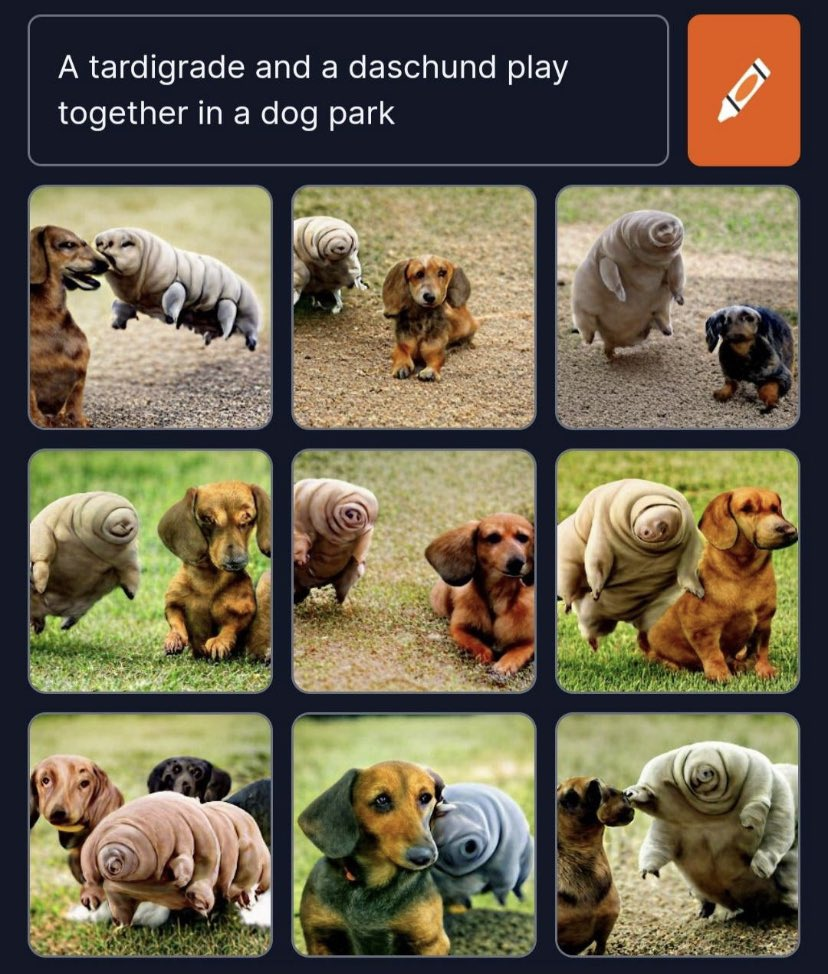

**But it is easy to break!!!**

But it loves messing up corporate logos...


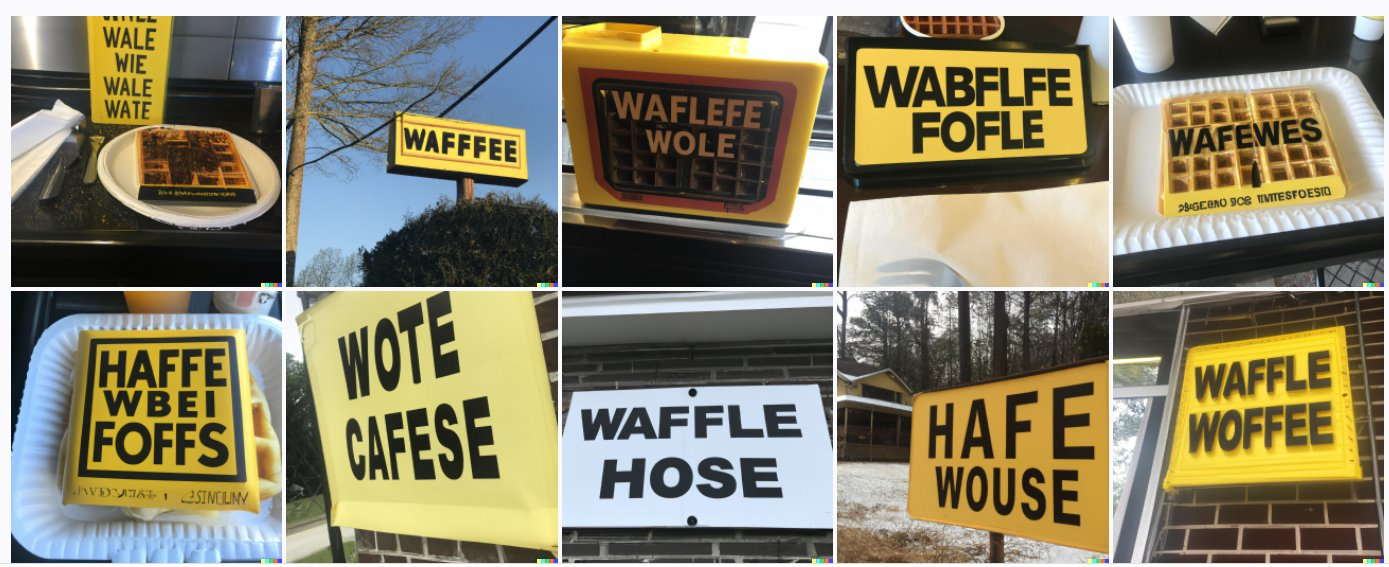

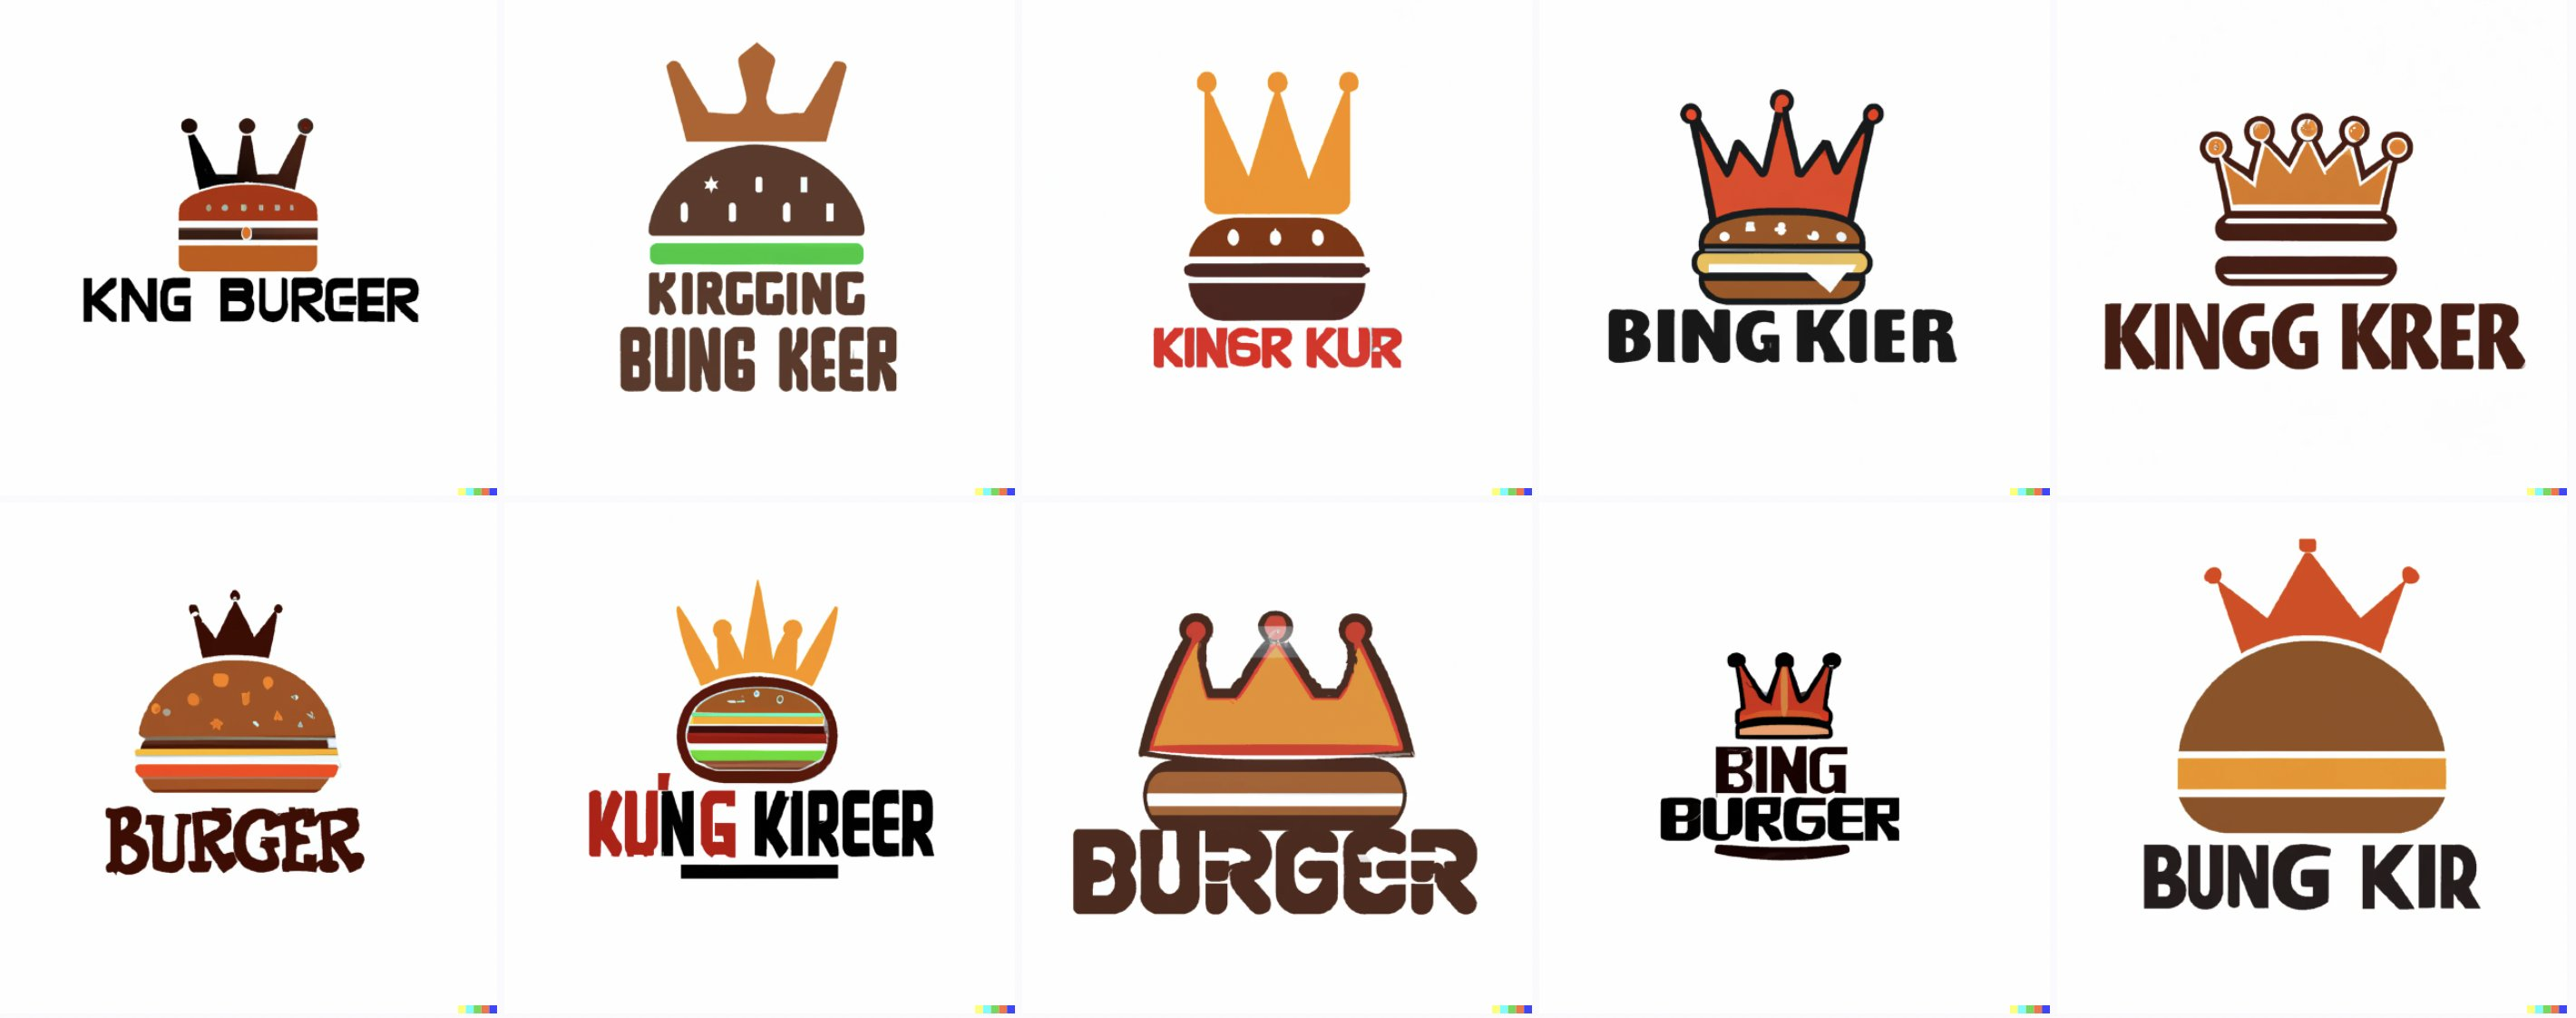

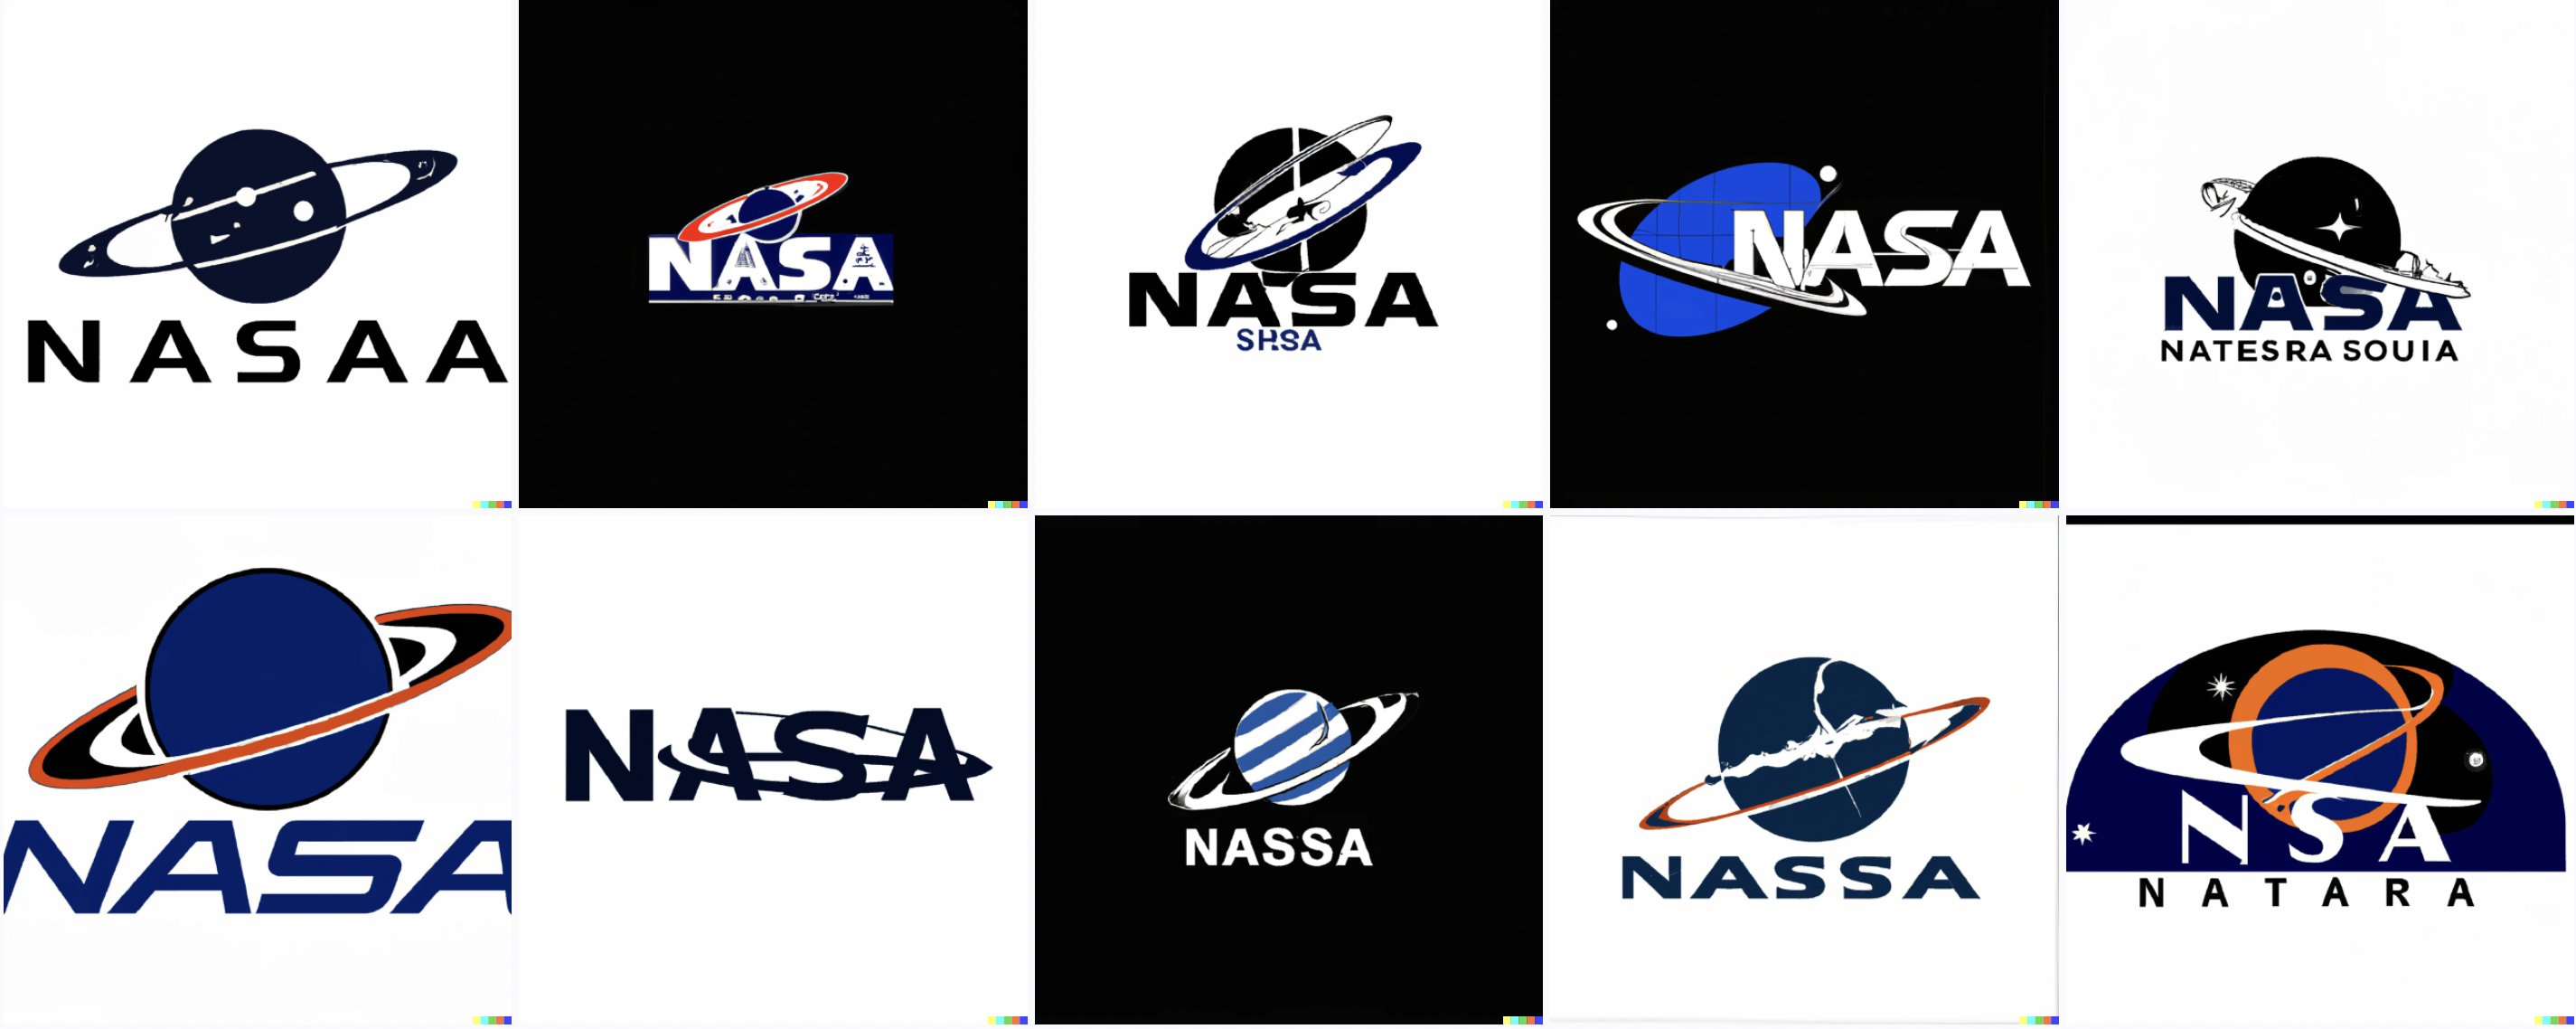